In [65]:
import numpy as np
from sdm.config import get_db_connection
from sdm.crud_embeddings import get_tweet_embeddings
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

## Get data from postgres

In [32]:
with get_db_connection(db_type="postgres") as db:
    df = get_tweet_embeddings(db)
df.head()

,id,text,doc_type,doc_id,embedding
0,5321,$1 trillion funding gap for poorest countries’...,tweet,671780808412254210,"[-0.13590758, 0.17315766, -0.008780155, 0.1163..."
1,5322,$3.4 Trillion: #Fossil ]Fuel Divestment Commit...,tweet,672364415400828932,"[0.00019094069, 0.17916173, -0.0056449766, 0.0..."
2,5323,$3.4 Trillion: #Fossil ]Fuel Divestment Commit...,tweet,672449986647330816,"[-0.00010863412, 0.18258078, -0.005554083, 0.0..."
3,5324,"$#COP21, Sassou Nguesso franc et direct. #sass...",tweet,672759702690922496,"[-0.083288014, 0.12386762, -0.013259346, 0.041..."
4,5325,$#COP21: Suivons les négociations et nous verr...,tweet,673645638286835712,"[-0.041687813, 0.22417882, -0.011368999, -0.05..."


In [33]:
print(type(df["embedding"][0]))
type(df["embedding"][0][0])

<class 'list'>


float

In [44]:
X = df["embedding"].tolist()
scores = []

# elbow method like in data mining
# for n_cluster in range(2, 60, 3):
# for n_cluster in range(2, 12):
for n_cluster in range(140, 300, 10):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(X)
    label = kmeans.labels_
    db_score = davies_bouldin_score(X, label)
    sil_score = silhouette_score(X, label)
    scores.append({
        "K": n_cluster,
        "inertia": kmeans.inertia_,
        "db": db_score,
        "silh": sil_score,
        })

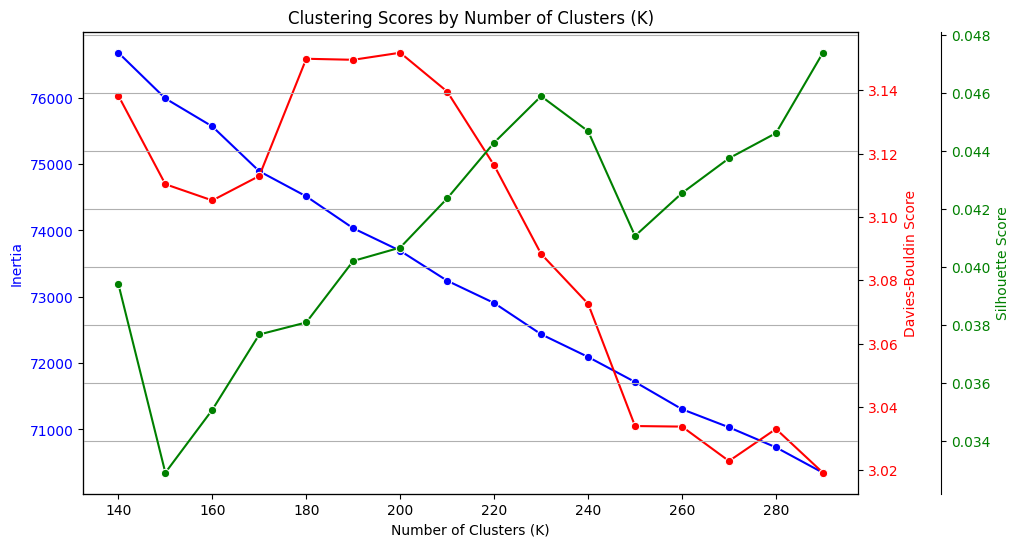

In [45]:
df_scores = pd.DataFrame(scores)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot inertia
sns.lineplot(data=df_scores, x="K", y="inertia", ax=ax1, color="blue", marker="o")
ax1.set_ylabel("Inertia", color="blue")
ax1.set_xlabel("Number of Clusters (K)")
ax1.tick_params(axis='y', labelcolor="blue")

# Create a second y-axis for the Davies-Bouldin score
ax2 = ax1.twinx()
sns.lineplot(data=df_scores, x="K", y="db", ax=ax2, color="red", marker="o")
ax2.set_ylabel("Davies-Bouldin Score", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Create a third y-axis for the Silhouette score
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third axis to avoid overlap
sns.lineplot(data=df_scores, x="K", y="silh", ax=ax3, color="green", marker="o")
ax3.set_ylabel("Silhouette Score", color="green")
ax3.tick_params(axis='y', labelcolor="green")

plt.title('Clustering Scores by Number of Clusters (K)')
plt.grid(True)
plt.show()

### 1. **Inertia (Sum of Squared Distances from Centroids)**
   - **Interpretation**: Inertia measures how internally cohesive the clusters are (i.e., how close the points are to their cluster centroids). Lower inertia values indicate that the clusters are more compact and well-defined.
   - **Trend**: Inertia will always decrease as `K` increases because more clusters means smaller clusters, so the centroids are closer to the points.
   - **How to Use**: Use the **elbow method** with inertia:
     - Plot inertia against `K` and look for a point where the decrease in inertia starts to slow down significantly. This point is often referred to as the **elbow**, and it suggests a good balance between cluster compactness and the number of clusters. Selecting `K` at or just before this elbow is a common approach.

### 2. **Davies-Bouldin (DB) Score**
   - **Interpretation**: The Davies-Bouldin score evaluates the average similarity ratio of each cluster with the cluster that is most similar to it. Lower DB scores indicate better clustering, where clusters are distinct and well-separated.
   - **Trend**: Lower DB scores are better. As `K` increases, the DB score typically decreases because the clusters are smaller and more distinct, but it can eventually stabilize or even increase if you overfit (too many clusters).
   - **How to Use**: Choose the value of `K` that minimizes the Davies-Bouldin score. This indicates that the clusters are well-separated and have minimal overlap.

### 3. **Silhouette Score**
   - **Interpretation**: The Silhouette score measures how similar each point is to its own cluster compared to other clusters. Values close to +1 indicate that the points are well-clustered, values close to 0 indicate overlapping clusters, and values close to -1 indicate that points are poorly clustered.
   - **Trend**: A higher silhouette score suggests better clustering, as points are well-grouped and far from other clusters. The score typically improves as `K` increases, but it may eventually plateau or decrease if too many clusters result in overfitting.
   - **How to Use**: Choose the value of `K` that maximizes the Silhouette score, as it suggests the optimal balance between cluster cohesion and separation.

In [46]:
K = 300
kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(X)
labels = kmeans.labels_

(31460,)

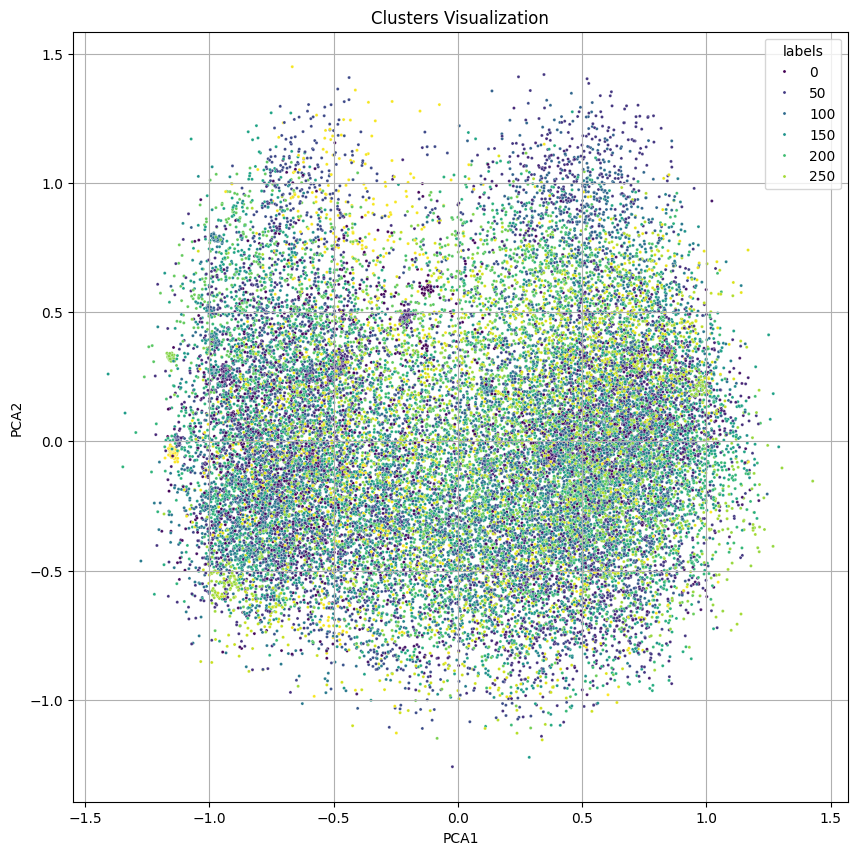

In [53]:
df["labels"] = labels
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(df["embedding"].tolist())

# Add reduced components to the dataframe for plotting
df['PCA1'] = X_reduced[:, 0]
df['PCA2'] = X_reduced[:, 1]

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PCA1', y='PCA2', hue='labels', palette='viridis', data=df, s=5)
plt.title('Clusters Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()

In [75]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(np.array(df["embedding"].tolist())) # tsne does not like list of lists :/

df['TSNE1'] = X_reduced[:, 0]
df['TSNE2'] = X_reduced[:, 1]

ValueError: Could not interpret value `label` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

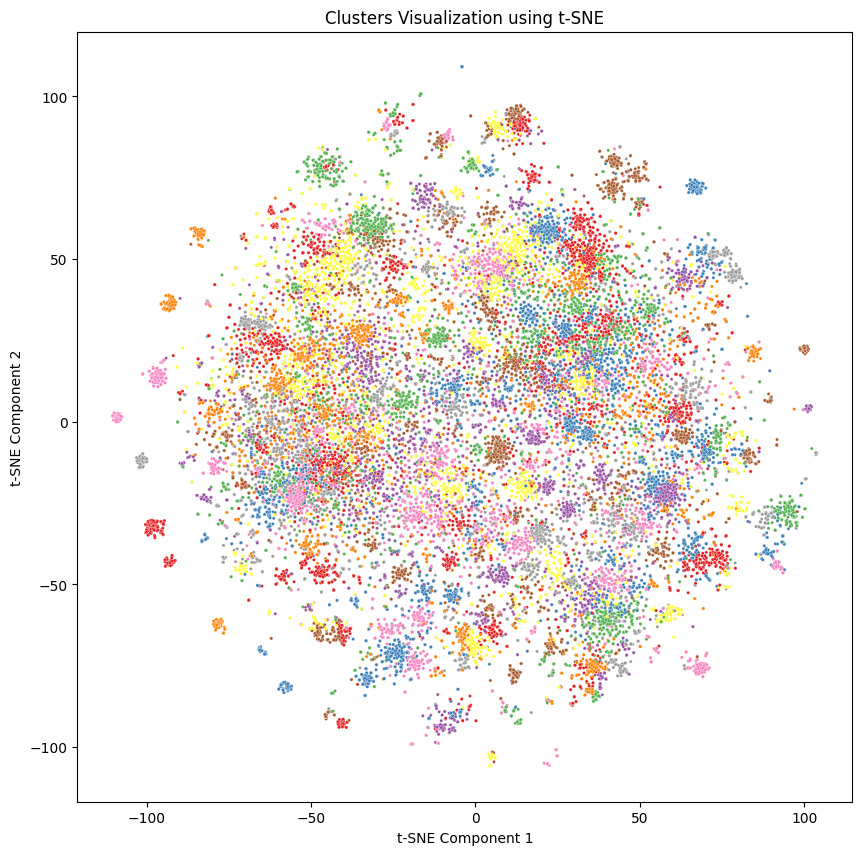

In [79]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='labels', palette='Set1', data=df, s=5, legend=False)

plt.title('Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [127]:
def intruder_detection(df, num_samples=3):
    cluster = df['labels'].sample(n=1).values[0]
    same_cluster_samples = df[df['labels'] == cluster].sample(n=2, random_state=42)
    different_cluster_samples = df[df['labels'] != cluster].sample(n=1, random_state=42)
    intruder_group = pd.concat([same_cluster_samples, different_cluster_samples])
    for _, row in intruder_group.sample(frac=1).iterrows():
        print(f"Text from Cluster {row['labels']}:\n{row['text']}\n{'-'*50}")

intruder_detection(df)

Text from Cluster 239:
"@350: It's #HumanRights Day at #COP21 --we support #rightsforall #genderjustice #justtransition #indigenousrights #womenclimatejustice"
--------------------------------------------------
Text from Cluster 239:
RT @Momentum_UNFCCC: Watch this launch for #M4C and #GenderDay at #COP21 - live webcast: https://t.co/VO0zRnhktw  https://t.co/RX2wkAbUr2
--------------------------------------------------
Text from Cluster 2:
RT DownToEarth: The #COP21 has officially started. Live on France24_en to have the latest on the opening of the co… https://t.co/6M9oRHM4Vt
--------------------------------------------------


In [115]:
df[["id", "labels"]].groupby("labels").count().describe()

,id
count,290.000000
mean,108.482759
std,63.279203
min,9.000000
25%,61.250000
50%,99.500000
75%,139.750000
max,336.000000
